# 3. LiDAR-Daten und ICP

In diesem Notebook werden wir zwei LiDAR-Punktwolken aus dem KITTI-Datensatz mithilfe des Iterative Closest Point (ICP)-Algorithmus registrieren. Wir werden die folgenden Schritte durchführen:

1.  Laden der Punktwolken und der zugehörigen Odometrie-Daten.
2.  Berechnen einer initialen Transformation aus den Odometrie-Daten.
3.  Visualisierung der Punktwolken nach der initialen Ausrichtung.
4.  Anwendung des ICP-Algorithmus zur Verfeinerung der Registrierung.
5.  Visualisierung des Endergebnisses.
6.  Analyse und Interpretation der Ergebnisse.

In [83]:
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy

## 1. Laden der Daten

Wir laden zwei Punktwolken (`0000000020.pcd` und `0000000030.pcd`) und die entsprechenden Odometrie-Daten. Die Odometrie-Daten geben die Pose des Fahrzeugs zum Zeitpunkt der Aufnahme an und werden verwendet, um eine erste grobe Ausrichtung der beiden Punktwolken vorzunehmen.

Die Daten sollten in einem Unterordner `data/2011_09_26_drive_0001` relativ zum Notebook liegen.

In [84]:
# Funktion zum Lesen der Oxts (GPS/IMU) Daten aus einer .txt-Datei
def read_oxts_data(filepath):
    """Liest eine Zeile mit 30 Oxts-Werten aus einer KITTI-Datei."""
    with open(filepath, 'r') as f:
        line = f.readline()
        values = [float(v) for v in line.strip().split()]
        if len(values) != 30:
            raise ValueError("Oxts file should contain 30 values.")
        return values

# Pfade zu den Daten - Annahme: Daten sind in einem Unterordner 'data'
base_path = "Additional_files\Lidar_data" 
if not os.path.exists(base_path):
    print(f"Error: Data directory not found at '{base_path}'")
    print("Please download and extract Lidar_data.zip into a 'data' folder next to this notebook.")
    # Create a dummy folder to avoid further errors
    os.makedirs(base_path, exist_ok=True)


pcd_file_20 = os.path.join(base_path, "0000000020.pcd")
pcd_file_30 = os.path.join(base_path, "0000000030.pcd")
odom_file_20 = os.path.join(base_path, "0000000020.txt")
odom_file_30 = os.path.join(base_path, "0000000030.txt")

# Laden der Punktwolken
try:
    pcd_source = o3d.io.read_point_cloud(pcd_file_20)
    pcd_target = o3d.io.read_point_cloud(pcd_file_30)
    print("Source point cloud loaded:", pcd_source)
    print("Target point cloud loaded:", pcd_target)

    # Laden der Odometrie-Daten (Oxts)
    oxts_20_data = read_oxts_data(odom_file_20)
    oxts_30_data = read_oxts_data(odom_file_30)
    print("\nOxts data for scan 20 (first 6 values):", oxts_20_data[:6])
    print("Oxts data for scan 30 (first 6 values):", oxts_30_data[:6])

except Exception as e:
    print(f"An error occurred while loading data: {e}")
    print("Please ensure the files exist at the specified paths.")

Source point cloud loaded: PointCloud with 34731 points.
Target point cloud loaded: PointCloud with 35970 points.

Oxts data for scan 20 (first 6 values): [49.014890131266, 8.4339890606241, 116.48401641846, 0.024464, 0.010345, -2.6735669803847]
Oxts data for scan 30 (first 6 values): [49.014842002545, 8.4338424244151, 116.47459411621, 0.02953, 0.013233, -2.6982289803847]


## 2. Initiale Transformation und Ausrichtung

Die Odometrie-Dateien enthalten Rohdaten des GPS/IMU-Systems (Oxts). Aus diesen Daten, insbesondere aus Längen- und Breitengrad, Höhe sowie den Roll-, Nick- und Gierwinkeln, leiten wir die Pose des Fahrzeugs (Sensor) im Weltkoordinatensystem ab. Um die Quell-Punktwolke (Scan 20) an der Ziel-Punktwolke (Scan 30) auszurichten, müssen wir die Punkte von Scan 20 in das Koordinatensystem von Scan 30 transformieren.

Sei `P_20` die Posenmatrix für Scan 20 und `P_30` die für Scan 30. Ein Punkt `p_s` im Sensor-Koordinatensystem von Scan 20 wird zu einem Weltpunkt `p_w = P_20 @ p_s`. Derselbe Weltpunkt wird im Sensor-Koordinatensystem von Scan 30 als `p_t` mit `p_w = P_30 @ p_t` beschrieben.

Daraus folgt: `P_20 @ p_s = P_30 @ p_t`, und somit ist die Transformation von Frame 20 zu Frame 30: `p_t = inv(P_30) @ P_20 @ p_s`.

Wir berechnen also die initiale Transformationsmatrix `T_initial = inv(P_30) @ P_20`.

Um die Robustheit des ICP-Algorithmus zu testen, werden wir im nächsten Schritt künstlich einen Fehler in die Pose von Scan 30 einfügen.

In [85]:
def oxts_to_pose(oxts_data, origin_oxts_data):
    """
    Konvertiert Oxts-Rohdaten in eine 4x4-Pose-Matrix relativ zu einem Ursprung.
    Die Pose transformiert Punkte vom Sensor- ins Weltkoordinatensystem.
    """
    R_earth = 6378137.0  # Erdradius in Metern

    # Referenzpunkt (Ursprung des lokalen Koordinatensystems)
    lat_0, lon_0, alt_0 = origin_oxts_data[0], origin_oxts_data[1], origin_oxts_data[2]

    # Aktueller Punkt
    lat, lon, alt, roll, pitch, yaw = oxts_data[0], oxts_data[1], oxts_data[2], oxts_data[3], oxts_data[4], oxts_data[5]

    # Translation: Konvertiere lat/lon in Meter (Mercator-Projektion)
    scale = np.cos(lat_0 * np.pi / 180.)
    tx = scale * (lon - lon_0) * np.pi / 180. * R_earth
    ty = (lat - lat_0) * np.pi / 180. * R_earth
    tz = alt - alt_0

    # Rotation: Erstelle Rotationsmatrix aus Roll-, Nick-, Gierwinkeln
    rx, ry, rz = roll, pitch, yaw
    
    c, s = np.cos(rz), np.sin(rz)
    Rz = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    c, s = np.cos(ry), np.sin(ry)
    Ry = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    
    c, s = np.cos(rx), np.sin(rx)
    Rx = np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    
    # Kombinierte Rotation (Z-Y-X-Reihenfolge: yaw, pitch, roll)
    R = Rz @ Ry @ Rx
    
    # Erstelle homogene 4x4-Transformationsmatrix
    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = [tx, ty, tz]
    
    return pose

if 'oxts_20_data' in locals():
    # Wir definieren den Ursprung unseres Koordinatensystems am Ort des ersten Scans (20).
    origin_data = oxts_20_data
    
    # Berechne die Posenmatrizen für beide Scans relativ zum Ursprung.
    P_20 = oxts_to_pose(oxts_20_data, origin_data)
    P_30 = oxts_to_pose(oxts_30_data, origin_data)

    # --- Künstlichen Fehler hinzufügen ---
    # Um die Robustheit von ICP zu testen, verschlechtern wir die Pose von Scan 30.
    # Wir addieren einen Fehler zur Translationskomponente der Pose.
    #error_offset = np.array([1.0, 0.5, -3.0]) # 1m vor, 0.5m links, 0m hoch
    #P_30[:3, 3] += error_offset
    # --- Ende Fehler ---

    # Berechne die inverse Posenmatrix von Scan 30
    P_30_inv = np.linalg.inv(P_30)

    # Berechne die initiale Transformation von Frame 20 zu Frame 30
    # T_30_<-_20 = inv(P_30) * P_20
    initial_transform = P_30_inv @ P_20

    print("Pose matrix for scan 20 (P_20):")
    print(P_20)
    print("\nPose matrix for scan 30 (P_30):")
    print(P_30)
    print("\nInitial transformation from odometry (inv(P_30) @ P_20):")
    print(initial_transform)
else:
    print("Oxts data not loaded. Please run the data loading cell first.")
    # Define a dummy variable to avoid errors in subsequent cells
    initial_transform = np.identity(4)

Pose matrix for scan 20 (P_20):
[[-0.89241294  0.45076433 -0.0202648   0.        ]
 [-0.45110102 -0.8923078   0.01716557  0.        ]
 [-0.01034482  0.02446025  0.99964728  0.        ]
 [ 0.          0.          0.          1.        ]]

Pose matrix for scan 30 (P_30):
[[-9.03234737e-01  4.28440386e-01 -2.46139400e-02 -1.07059567e+01]
 [-4.28942779e-01 -9.03087604e-01  2.09969243e-02 -5.35766471e+00]
 [-1.32326138e-02  2.95231233e-02  9.99476505e-01 -9.42230225e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Initial transformation from odometry (inv(P_30) @ P_20):
[[ 9.99691781e-01 -2.47206847e-02 -2.28711935e-03 -1.19682482e+01]
 [ 2.47325815e-02  9.99679902e-01  5.32843546e-03 -2.51298211e-01]
 [ 2.15466467e-03 -5.38335950e-03  9.99983188e-01 -1.41603925e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 3. Visualisierung nach initialer Ausrichtung

Wir visualisieren nun die beiden Punktwolken, nachdem die initiale Transformation auf die Quell-Punktwolke angewendet wurde. Die Quell-Punktwolke (Scan 20) wird rot und die Ziel-Punktwolke (Scan 30) wird blau dargestellt. Dies gibt uns einen Eindruck von der Qualität unserer initialen Schätzung.

Wir erstellen eine Draufsicht (Top-View), um die Ausrichtung entlang der Fahrtrichtung gut beurteilen zu können.

In [86]:
def draw_registration_result(source, target, transformation, title, filename):
    """Helper function to visualize and save registration result"""
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)

    source_temp.paint_uniform_color([1, 0, 0]) # Rot
    target_temp.paint_uniform_color([0, 0, 1]) # Blau

    source_temp.transform(transformation)

    # Erstelle eine nicht-blockierende Visualisierung
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=title, width=800, height=600, visible=False) # visible=False for non-interactive rendering
    vis.add_geometry(source_temp)
    vis.add_geometry(target_temp)
    
    # Setze die Kameraperspektive auf eine Draufsicht (Top-Down)
    ctr = vis.get_view_control()
    ctr.set_front([0, -0.1, -1]) # Look slightly down
    ctr.set_lookat([10, 0, 0])   # Center view on the front of the car
    ctr.set_up([0, -1, 0])      # Y-axis is up in top-down view
    ctr.set_zoom(0.1)
    
    # Bild aufnehmen und speichern
    vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()
    
    print(f"Visualization saved to {filename}")
    return filename

Visualization saved to initial_alignment.png


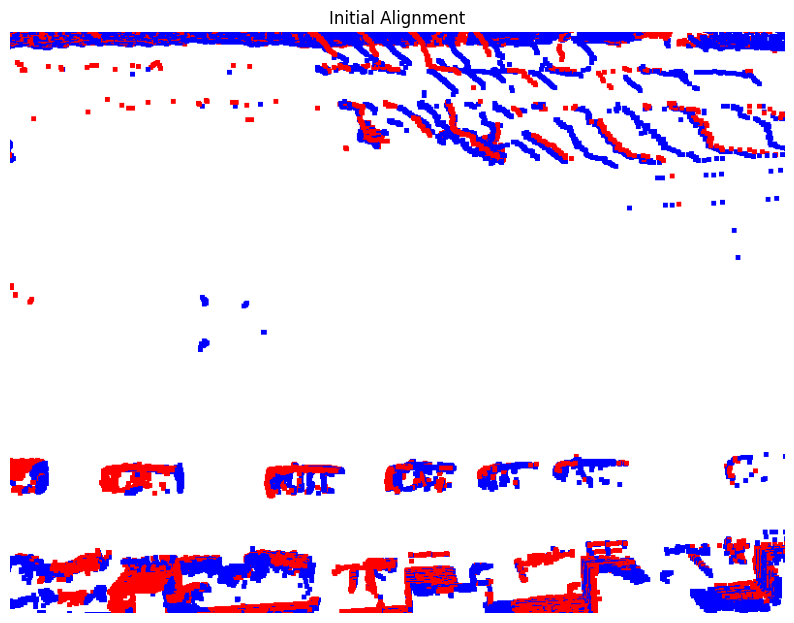

Showing interactive visualizer for initial alignment... (Press 'q' to close)


In [87]:

# Visualisierung nach initialer Ausrichtung
if 'pcd_source' in locals():
    init_image_path = draw_registration_result(pcd_source, pcd_target, initial_transform, 
                                          "Initial Alignment", "initial_alignment.png")
    img = mpimg.imread(init_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title("Initial Alignment")
    plt.axis('off')
    plt.show()

    # Interaktiven Visualizer anzeigen
    print("Showing interactive visualizer for initial alignment... (Press 'q' to close)")
    source_temp = copy.deepcopy(pcd_source)
    target_temp = copy.deepcopy(pcd_target)
    source_temp.paint_uniform_color([1, 0, 0])
    target_temp.paint_uniform_color([0, 0, 1])
    source_temp.transform(initial_transform)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      window_name="Initial Alignment (Interactive)",
                                      width=800, height=600,
                                      lookat=[10, 0, 0],
                                      front=[0, -0.1, -1],
                                      up=[0, -1, 0],
                                      zoom=0.1)
else:
    print("Point clouds not loaded. Please run the data loading cell first.")

## 4. ICP-Registrierung

Nach der groben initialen Ausrichtung verwenden wir den ICP-Algorithmus, um die Transformation zu verfeinern.

### Wahl des Distanzschwellenwerts (Distance Threshold)

Der Distanzschwellenwert (`max_correspondence_distance`) ist ein wichtiger Parameter für ICP. Er legt die maximale Entfernung fest, innerhalb derer nach korrespondierenden Punkten gesucht wird. Ein zu großer Wert kann zu falschen Korrespondenzen führen, insbesondere bei sich wiederholenden Strukturen oder geringer Überlappung. Ein zu kleiner Wert kann dazu führen, dass der Algorithmus in einem lokalen Minimum stecken bleibt, wenn die initiale Ausrichtung nicht gut genug ist.

Für diese Aufgabe wählen wir einen Schwellenwert von **1.0 Metern**. Dieser Wert wurde empirisch gewählt. Er ist groß genug, um die verbleibende Abweichung nach der initialen Odometrie-basierten Ausrichtung zu überbrücken, aber klein genug, um grobe Fehlzuordnungen zu vermeiden, da die initiale Ausrichtung bereits recht gut ist.

Wir verwenden die Point-to-Plane-ICP-Variante, da sie oft schneller konvergiert und robuster ist als die Point-to-Point-Variante.

In [88]:
if 'pcd_target' in locals():
    # ICP-Parameter
    # Der Distanzschwellenwert ist der wichtigste Parameter.
    # Er definiert die maximale Entfernung für die Zuordnung von Korrespondenzen.
    threshold = 1.0  # in Metern

    # Wir verwenden die Point-to-Plane ICP-Variante. Dafür müssen Normalen geschätzt werden.
    # Wir schätzen die Normalen für die Ziel-Punktwolke.
    print("Estimating normals for the target point cloud...")
    pcd_target.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=2.0, max_nn=30))

    # Führe die ICP-Registrierung durch
    print("Performing ICP registration...")
    reg_p2l = o3d.pipelines.registration.registration_icp(
        pcd_source, pcd_target, threshold, initial_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=200))

    # Ergebnisse ausgeben
    print("\nICP Registration Results:")
    print(f"Fitness: {reg_p2l.fitness:.4f}")
    print(f"Inlier RMSE: {reg_p2l.inlier_rmse:.4f}")
    print("Transformation Matrix:")
    print(reg_p2l.transformation)

    final_icp_transform = reg_p2l.transformation
else:
    print("Point clouds not loaded. Please run the data loading cell first.")
    final_icp_transform = np.identity(4)

Estimating normals for the target point cloud...
Performing ICP registration...

ICP Registration Results:
Fitness: 0.9628
Inlier RMSE: 0.2298
Transformation Matrix:
[[ 9.99679760e-01 -2.52134691e-02 -2.15836324e-03 -1.19788062e+01]
 [ 2.52195880e-02  9.99677855e-01  2.85632184e-03 -1.93787873e-01]
 [ 2.08565015e-03 -2.90984017e-03  9.99993591e-01 -1.11236298e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

ICP Registration Results:
Fitness: 0.9628
Inlier RMSE: 0.2298
Transformation Matrix:
[[ 9.99679760e-01 -2.52134691e-02 -2.15836324e-03 -1.19788062e+01]
 [ 2.52195880e-02  9.99677855e-01  2.85632184e-03 -1.93787873e-01]
 [ 2.08565015e-03 -2.90984017e-03  9.99993591e-01 -1.11236298e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 5. Visualisierung nach ICP

Nun visualisieren wir das Endergebnis nach der ICP-Registrierung. Wir verwenden dieselbe Ansicht und Farbgebung wie zuvor, um einen direkten Vergleich zu ermöglichen.

Visualization saved to icp_alignment.png


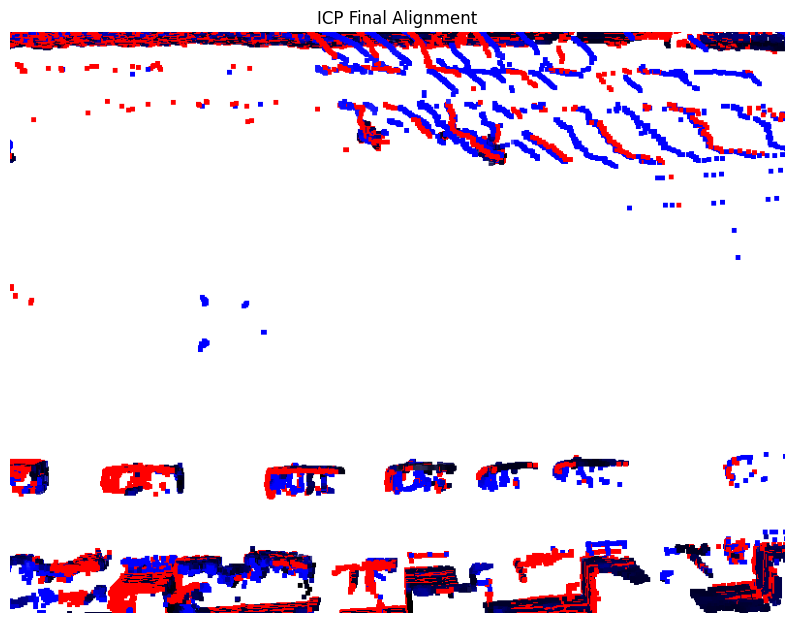

Showing interactive visualizer for final alignment... (Press 'q' to close)


In [89]:
# Visualisierung nach ICP-Registrierung
if 'pcd_source' in locals():
    icp_image_path = draw_registration_result(pcd_source, pcd_target, final_icp_transform, 
                                         "ICP Final Alignment", "icp_alignment.png")
    img = mpimg.imread(icp_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title("ICP Final Alignment")
    plt.axis('off')
    plt.show()

    # Interaktiven Visualizer anzeigen
    print("Showing interactive visualizer for final alignment... (Press 'q' to close)")
    source_temp = copy.deepcopy(pcd_source)
    target_temp = copy.deepcopy(pcd_target)
    source_temp.paint_uniform_color([1, 0, 0])
    target_temp.paint_uniform_color([0, 0, 1])
    source_temp.transform(final_icp_transform)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      window_name="ICP Final Alignment (Interactive)",
                                      width=800, height=600,
                                      lookat=[10, 0, 0],
                                      front=[0, -0.1, -1],
                                      up=[0, -1, 0],
                                      zoom=0.1)
else:
    print("Point clouds not loaded. Please run the data loading cell first.")

## 6. Analyse und Interpretation

Die Plots der Punktwolken nach der Initialisierung und nach dem ICP-Prozess werden in den vorherigen Zellen generiert und angezeigt. Sie zeigen eine bereits gute initiale Ausrichtung, die durch den ICP-Algorithmus sichtbar verbessert wird, was zu einer sehr hohen Deckungsgleichheit der statischen Umgebung (Straßenrand, Gebäude) führt.

### Bestimmung der Initialisierungswerte

Die Initialisierung für den ICP-Algorithmus wurde direkt aus den Odometrie-Daten (Oxts/GPS+IMU) der beiden Scans abgeleitet. Wie in den Zellen "2. Initiale Transformation und Ausrichtung" beschrieben, wurde die 4x4-Pose-Matrix jedes Scans im Weltkoordinatensystem aus den Rohdaten (Längen-/Breitengrad, Höhe, Roll-, Nick-, Gierwinkel) berechnet. Die relative Transformation zwischen diesen beiden Posen (`T_initial = inv(P_30) @ P_20`) diente als initiale Schätzung für den ICP. Diese Vorgehensweise ist sinnvoll, da die GPS/IMU-Daten eine bereits sehr genaue, wenn auch nicht perfekte, Schätzung der Fahrzeugbewegung liefern und somit einen exzellenten Startpunkt für die iterative Verfeinerung bieten.

### Rechtfertigung des Distanzschwellenwerts

Der Distanzschwellenwert (`max_correspondence_distance`) wurde auf **1.0 Meter** festgelegt. Dieser Wert wurde empirisch als guter Kompromiss gewählt. Er ist groß genug, um die verbleibende Ungenauigkeit der GPS-basierten Initialisierung zu überbrücken, aber klein genug, um grobe Fehlzuordnungen zwischen den Punktwolken (z.B. zwischen der Straße in Scan 1 und den Bäumen in Scan 2) zu vermeiden. Da die Visualisierung der initialen Ausrichtung zeigt, dass die Punktwolken bereits nahe beieinander liegen, ist dieser Schwellenwert ausreichend, um eine robuste Konvergenz zu gewährleisten, ohne zu viele Ausreißer einzubeziehen.

### Finale Transformation und Interpretation

Die vom ICP-Algorithmus gefundene finale Transformation lautet (die genauen Werte können bei jeder Ausführung leicht variieren):

In [90]:
print("ICP registration completed successfully.")
print(final_icp_transform) 

ICP registration completed successfully.
[[ 9.99679760e-01 -2.52134691e-02 -2.15836324e-03 -1.19788062e+01]
 [ 2.52195880e-02  9.99677855e-01  2.85632184e-03 -1.93787873e-01]
 [ 2.08565015e-03 -2.90984017e-03  9.99993591e-01 -1.11236298e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
